In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import lightgbm as lgb


In [48]:
path = '/data/GAMMA_hackathon/'
!ls {path}
df = pd.read_csv(path + 'customer_data.csv')

 customer_data.csv	 'Gammathon attendee Instructions.pdf'
 example_submission.csv


In [60]:
submission = pd.read_csv('e.csv')

In [3]:
df2 = pd.read_csv('eres.csv')

In [5]:
df2.churned.astype(float).mean()

0.043179773230141626

In [49]:
df = df.sort_values('month')

In [50]:
df.describe()

,customer_id,months_since_joined,referred_friends,transaction_count,transaction_value,clv,total_reward_points,earned_reward_points
count,1.143614e+07,1.143614e+07,1.143614e+07,1.143614e+07,1.143614e+07,1.143614e+07,1.143614e+07,1.143614e+07
mean,6.086582e+05,2.210391e+01,9.669775e-01,2.936650e+01,1.504392e+02,3.600556e+03,5.648918e+03,2.941982e+02
std,2.847427e+05,1.978018e+01,9.877185e-01,1.471019e+01,1.645431e+02,5.712062e+03,1.374896e+04,5.555236e+02
min,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.067390e+05,6.000000e+00,0.000000e+00,1.900000e+01,5.816020e+01,4.291993e+02,2.759791e+02,4.600000e+01
50%,6.195790e+05,1.600000e+01,1.000000e+00,2.600000e+01,8.558780e+01,1.130037e+03,1.068997e+03,1.000000e+02
75%,8.241590e+05,3.400000e+01,2.000000e+00,3.600000e+01,1.718362e+02,4.080206e+03,4.421000e+03,2.660000e+02
max,1.204356e+06,9.300000e+01,9.000000e+00,1.410000e+02,1.929116e+03,6.423930e+04,4.863967e+05,1.238400e+04


In [171]:
df2[df2.customer_id.isin(submission.customer_id)].churned.describe()

count      1201
unique        2
top       False
freq       1200
Name: churned, dtype: object

In [51]:
df.dtypes

customer_id               int64
month                    object
months_since_joined       int64
referred_friends          int64
transaction_count       float64
transaction_value       float64
clv                     float64
total_reward_points     float64
earned_reward_points    float64
cluster                  object
churned                    bool
dtype: object

In [109]:
train = (df.customer_id % 10) < 8

In [110]:
cont = ['referred_friends', 'months_since_joined']
for cat in cont:
    df[cat] = df[cat].astype(float)

In [111]:
cum_features =  ['referred_friends', 'transaction_count', 'transaction_value', 'earned_reward_points']

In [112]:
for feat in cum_features:
    df['cum_'+feat] = df.groupby('customer_id')[feat].cumsum()

In [113]:
cats = ['cluster']
for cat in cats:
    df[cat] = pd.Categorical(df[cat])

In [114]:
features = cum_features + ['cum_' + feat for feat in cum_features] + ['cluster', 'clv']


In [115]:
df['label'] = df.groupby('customer_id').churned.shift(-1)
df_clean = df.dropna(axis=0, subset=['label'])
train = (df_clean.customer_id % 10) < 8

x_train = df_clean[train]
x_test = df_clean[~train]

y_train = df_clean[train]['label'].astype(bool)
y_test = df_clean[~train]['label'].astype(bool)

# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train[features], y_train)
lgb_eval = lgb.Dataset(x_test[features], y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'application': 'binary',
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)


Starting training...
[1]	valid_0's binary_logloss: 0.179707
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.177029
[3]	valid_0's binary_logloss: 0.174763
[4]	valid_0's binary_logloss: 0.172952
[5]	valid_0's binary_logloss: 0.171558
[6]	valid_0's binary_logloss: 0.17041
[7]	valid_0's binary_logloss: 0.169417
[8]	valid_0's binary_logloss: 0.168619
[9]	valid_0's binary_logloss: 0.167911
[10]	valid_0's binary_logloss: 0.167277
[11]	valid_0's binary_logloss: 0.166727
[12]	valid_0's binary_logloss: 0.166236
[13]	valid_0's binary_logloss: 0.16581
[14]	valid_0's binary_logloss: 0.165437
[15]	valid_0's binary_logloss: 0.165093
[16]	valid_0's binary_logloss: 0.16482
[17]	valid_0's binary_logloss: 0.164526
[18]	valid_0's binary_logloss: 0.164292
[19]	valid_0's binary_logloss: 0.164045
[20]	valid_0's binary_logloss: 0.163819
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.163819


In [68]:
x_train['p'] = gbm.predict(x_train[features])
x_test['p'] = gbm.predict(x_test[features])

/home/anton/code/BCGHack/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/anton/code/BCGHack/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
df_p = pd.concat([x_train, x_test])

In [70]:
df_p['value'] = df_p['p'] * df_p['clv']

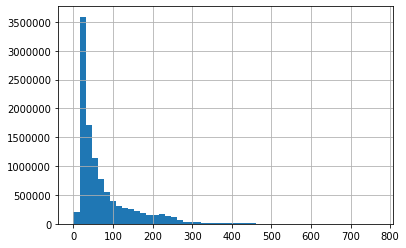

In [71]:
df_p.value.hist(bins=50)

In [72]:
best_step_1 = df_p.sort_values('value').iloc[-10000:]

In [73]:
best_step_1.p.mean()

0.012279225480220998

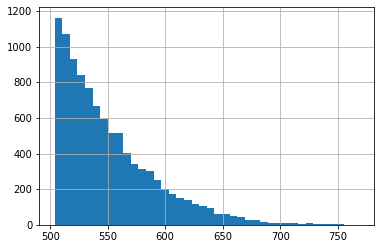

In [74]:
best_step_1.value.hist(bins=40)

In [75]:
best_step_1.cluster.value_counts()

B    6705
C    2425
A     870
Name: cluster, dtype: int64

In [84]:
lasts = df_p.groupby('customer_id').tail(1)
joined = lasts.join(df2, 'customer_id', rsuffix='_2', how='inner')


In [77]:
gb = joined.groupby('cluster')
(joined.p.mean(), joined.churned_2.astype(float).mean())

(0.025006219260969107, 0.04794646412054761)

In [78]:
joined.cluster.value_counts()

B    33298
C    19457
A    12547
Name: cluster, dtype: int64

In [91]:
submission

,customer_id
0,32498
1,40708
2,81815
3,167357
4,75355
...,...
9995,31970
9996,31970
9997,60153
9998,31970


In [92]:
submission['submitted'] = True

In [95]:
joined2 = joined.join(submission, 'customer_id', how='left', rsuffix='_2')

In [102]:
joined2['churnedf'] = joined2.churned.astype(float)
joined2 = joined2['submitted'].fillna(False)
joined2.groupby(submitted).churnedf.mean()

AttributeError: 'Series' object has no attribute 'churned'

In [99]:
joined2

,customer_id,month,months_since_joined,referred_friends,transaction_count,transaction_value,clv,total_reward_points,earned_reward_points,cluster,...,transaction_count_2,transaction_value_2,clv_2,total_reward_points_2,earned_reward_points_2,cluster_2,churned_2,customer_id_2,submitted,churnedf
34173,186083,2016-02-01,33.0,3.0,6.0,38.793841,1037.916931,358.078171,6.0,A,...,40.0,99.382632,1176.037331,1946.130133,160.0,B,False,NaN,NaN,0.0
34049,185500,2016-02-01,33.0,0.0,35.0,35.000000,936.413923,1389.120566,35.0,A,...,30.0,75.215881,890.061796,704.996608,90.0,C,False,NaN,NaN,0.0
34376,187117,2016-02-01,33.0,0.0,1.0,1.000000,26.754684,402.904909,0.0,A,...,36.0,134.034871,1586.092132,1541.918997,216.0,C,False,NaN,NaN,0.0
34384,187157,2016-02-01,33.0,1.0,7.0,52.846386,1413.888324,1742.933895,14.0,C,...,24.0,95.411141,1129.040968,1105.490050,96.0,B,False,NaN,NaN,0.0
34225,186311,2016-02-01,33.0,0.0,5.0,42.706706,1142.604399,2012.508869,10.0,B,...,10.0,34.735734,411.042842,408.276624,10.0,B,False,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10834533,252778,2019-08-01,69.0,1.0,71.0,1080.005832,35759.938758,94472.973805,3834.0,B,...,21.0,45.198751,298.723856,150.716356,42.0,A,False,NaN,NaN,0.0
10834530,252768,2019-08-01,69.0,0.0,44.0,632.222067,20933.426236,36450.999261,1364.0,B,...,15.0,46.103534,304.703670,157.578580,30.0,C,True,NaN,NaN,0.0
10834575,253079,2019-08-01,69.0,0.0,36.0,73.188401,2423.332037,9866.832224,108.0,B,...,24.0,66.630330,440.367681,290.999873,72.0,B,False,NaN,NaN,0.0
10834524,252718,2019-08-01,69.0,1.0,42.0,387.636399,12834.980579,22012.869379,798.0,B,...,23.0,75.653199,500.000879,460.999590,69.0,B,False,NaN,NaN,0.0


In [96]:
len(joined2)

65302

In [86]:
len(df2)

312299

In [87]:
len(joined)

65302

In [90]:
len(lasts)

761635

In [22]:
x_train.head()

,referred_friends,transaction_count,transaction_value,earned_reward_points,cum_referred_friends,cum_transaction_count,cum_transaction_value,cum_earned_reward_points,cluster,clv
343319,1,16.0,49.038831,32.0,1,31.0,94.093606,62.0,A,379.213933
343318,0,18.0,70.531096,54.0,1,34.0,129.344747,86.0,A,545.412153
343317,0,15.0,47.805180,30.0,3,31.0,95.487264,62.0,C,369.674190
343315,1,25.0,71.703089,75.0,2,49.0,144.292021,147.0,B,554.475087
343314,1,20.0,69.553305,60.0,1,40.0,137.524225,120.0,C,537.850958


In [24]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [40]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

/home/anton/code/BCGHack/venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: False

In [35]:
x_train.dtypes

referred_friends              int64
transaction_count           float64
transaction_value           float64
earned_reward_points        float64
cum_referred_friends          int64
cum_transaction_count       float64
cum_transaction_value       float64
cum_earned_reward_points    float64
cluster                        int8
clv                         float64
dtype: object

In [64]:
df.groupby('customer_id').churned.shift(-1).value_counts()

False    10123714
True       475591
Name: churned, dtype: int64

In [65]:
df.churned.value_counts()

False    10900272
True       535866
Name: churned, dtype: int64

In [ ]:
## step2  ###

In [103]:
dfall = pd.concat([df, df2])

/home/anton/code/BCGHack/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [104]:
dfall = dfall.sort_values('month')

In [105]:
dfall.describe()

,clv,cum_earned_reward_points,cum_referred_friends,cum_transaction_count,cum_transaction_value,customer_id,earned_reward_points,months_since_joined,referred_friends,total_reward_points,transaction_count,transaction_value
count,1.174844e+07,1.143614e+07,1.143614e+07,1.143614e+07,1.143614e+07,1.174844e+07,1.174844e+07,1.174844e+07,1.174844e+07,1.174844e+07,1.174844e+07,1.174844e+07
mean,3.634193e+03,4.356872e+03,1.386087e+01,4.261847e+02,2.248129e+03,6.146858e+05,2.975513e+02,2.223146e+01,9.670399e-01,5.752907e+03,2.942922e+01,1.513609e+02
std,5.775117e+03,1.121846e+04,1.201230e+01,4.880609e+02,3.903332e+03,2.883516e+05,5.645690e+02,1.993022e+01,9.877004e-01,1.408958e+04,1.479195e+01,1.663061e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.302747e+02,2.300000e+02,4.000000e+00,9.200000e+01,2.778501e+02,4.097360e+05,4.600000e+01,6.000000e+00,0.000000e+00,2.769998e+02,1.900000e+01,5.821821e+01
50%,1.136915e+03,8.180000e+02,1.000000e+01,2.440000e+02,8.187363e+02,6.244800e+05,1.000000e+02,1.600000e+01,1.000000e+00,1.076000e+03,2.600000e+01,8.576929e+01
75%,4.114752e+03,3.169000e+03,2.100000e+01,5.780000e+02,2.363667e+03,8.331070e+05,2.700000e+02,3.400000e+01,2.000000e+00,4.468965e+03,3.600000e+01,1.727299e+02
max,6.527097e+04,3.943060e+05,7.500000e+01,5.436000e+03,6.588992e+04,1.215688e+06,1.261000e+04,9.400000e+01,9.000000e+00,4.966897e+05,1.410000e+02,1.959910e+03


In [116]:
trainall = (dfall.customer_id % 10) < 8

In [124]:
cont = ['referred_friends', 'months_since_joined']
for cat in cont:
    dfall[cat] = dfall[cat].astype(float)

In [125]:
cum_features =  ['referred_friends', 'transaction_count', 'transaction_value', 'earned_reward_points']

In [126]:
for feat in cum_features:
    dfall['cum_'+feat] = dfall.groupby('customer_id')[feat].cumsum()

In [131]:
cats = ['cluster']
for cat in cats:
    dfall[cat] = pd.Categorical(dfall[cat]).codes

In [132]:
features = cum_features + ['cum_' + feat for feat in cum_features] + ['cluster', 'clv']


In [133]:
dfall[features].dtypes

referred_friends            float64
transaction_count           float64
transaction_value           float64
earned_reward_points        float64
cum_referred_friends        float64
cum_transaction_count       float64
cum_transaction_value       float64
cum_earned_reward_points    float64
cluster                        int8
clv                         float64
dtype: object

In [174]:
dfall['label'] = dfall.groupby('customer_id').churned.shift(-1)
df_clean = dfall.dropna(axis=0, subset=['label'])
train = (df_clean.customer_id % 10) < 8

x_train = df_clean[train]
x_test = df_clean[~train]

y_train = df_clean[train]['label'].astype(bool)
y_test = df_clean[~train]['label'].astype(bool)

# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train[features], y_train)
lgb_eval = lgb.Dataset(x_test[features], y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'application': 'binary',
    'verbose': 0,
    'eta':0.1
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)


Starting training...
[1]	valid_0's binary_logloss: 0.179433
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.176746
[3]	valid_0's binary_logloss: 0.174464
[4]	valid_0's binary_logloss: 0.172654
[5]	valid_0's binary_logloss: 0.17124
[6]	valid_0's binary_logloss: 0.170099
[7]	valid_0's binary_logloss: 0.169139
[8]	valid_0's binary_logloss: 0.168288
[9]	valid_0's binary_logloss: 0.167607
[10]	valid_0's binary_logloss: 0.167002
[11]	valid_0's binary_logloss: 0.166455
[12]	valid_0's binary_logloss: 0.165946
[13]	valid_0's binary_logloss: 0.16553
[14]	valid_0's binary_logloss: 0.165134
[15]	valid_0's binary_logloss: 0.16479
[16]	valid_0's binary_logloss: 0.164478
[17]	valid_0's binary_logloss: 0.164182
[18]	valid_0's binary_logloss: 0.163932
[19]	valid_0's binary_logloss: 0.163709
[20]	valid_0's binary_logloss: 0.163511
[21]	valid_0's binary_logloss: 0.163329
[22]	valid_0's binary_logloss: 0.163156
[23]	valid_0's binary_logloss: 0.163
[24]	valid_0's

In [175]:
x_train['p'] = gbm.predict(x_train[features])
x_test['p'] = gbm.predict(x_test[features])

/home/anton/code/BCGHack/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/anton/code/BCGHack/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [176]:
lasts = dfall.sort_values('month').groupby('customer_id').tail(1)

In [177]:
to_pred = lasts[(~lasts.churned) & ~lasts.customer_id.isin(set(submission.customer_id))]

In [178]:
len(to_pred)

297614

In [179]:
to_pred['p'] = gbm.predict(to_pred[features])

/home/anton/code/BCGHack/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [180]:
to_pred['value'] = to_pred['p'] * to_pred['clv']

/home/anton/code/BCGHack/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


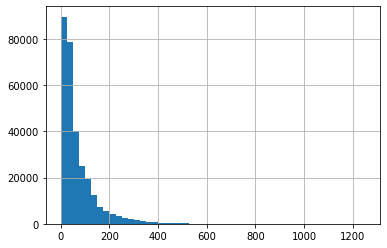

In [181]:
to_pred.value.hist(bins=50)

In [182]:
to_pred[to_pred.value > 51][['customer_id']].to_csv('e.csv', index=False)

In [136]:
df_p = pd.concat([x_train, x_test])

In [137]:
df_p['value'] = df_p['p'] * df_p['clv']

In [157]:
y_test.value_counts()

False    2082281
True       97885
Name: label, dtype: int64

In [153]:
df_p.churned.value_counts()

False    10900272
Name: churned, dtype: int64

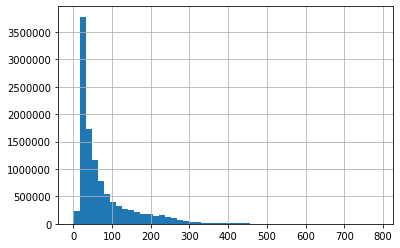

In [138]:
df_p.value.hist(bins=50)

In [142]:
submission

,customer_id,submitted
0,32498,True
1,40708,True
2,81815,True
3,167357,True
4,75355,True
...,...,...
9995,31970,True
9996,31970,True
9997,60153,True
9998,31970,True


In [145]:
lasts_p = df_p.sort_values('month').groupby('customer_id').tail(1)

In [147]:
len(lasts_p)

776558

In [148]:
len(lasts_p[~lasts_p.churned])

776558

In [143]:
len(df_p[~df_p.customer_id.isin(set(submission.customer_id))])

10846954

In [144]:
len(df_p)

10900272

In [139]:
best_step_1 = df_p.sort_values('value').iloc[-10000:]

In [140]:
best_step_1.p.mean()

0.012245298972171996

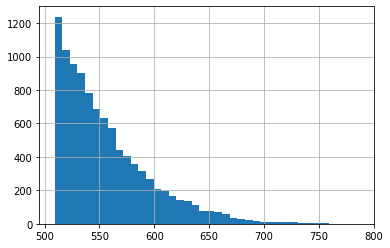

In [141]:
best_step_1.value.hist(bins=40)